# Credit Card Fraud Analysis and Modeling

From traditional to emerging sectors, there is not one single business that is fully immune from fraud. Some studies show that frauds of various kinds could cost businesses 1%-1.75% of their annual sales, this translates to around \$200 billion a year!

As one of the most common types of fraudulent activities, credit card transaction fraud impacts around 127 million people, or approximately \$8 billion in attempted fraudulent charges on Americans’ credit and debit cards. It is therefore imperative for credit card companies to understand the characteristics of a fraudulent transaction and develop predictive models accordingly to flag down potentially risky activities for fraud prevention.


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing

# The Dataset

In this project, we are examining the Credit Card Transactions Fraud Detection Dataset. We will first perform an exploratory data analysis to the data to understand which features might be correlated to fraudulent activities and then attempt to create models with those features and test out their predicitve effectiveness. 

# Preparation



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import plotly.express as px
sns.set(rc = {'figure.figsize':(15,8)})

In [5]:
df=pd.read_csv('/content/drive/MyDrive/insaid/fraudTrain.csv') 

In [6]:
#check shape of dataset
df.shape

(1296675, 23)

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(1296675, 23)

As can be seen from the results above, the dataset contains 23 columns that detail the time of the credit card transaction, the merchant, the spending category, the transaction amount, and personal infomration about the credit card holders, including their names, genders, locations and birthdays. It also contains a column called "is_fraud" which marks fraudulent transactions as 1 and non-fraudulent as 0. There is no missing data in the dataset and we also remove any duplicated observations in the data set to make it ready for further analysis.

# Exploratory Data Analysis
## 1. Transaction amount vs Fraud

With the dataset cleaned, we can now start to examine how various features relate to fraud. First we will see how the distrition of transaction amount differs between fraudulent and normal activities. As there are extreme outliers in transaction amount, and the 99 percentile is around \\$546, we subset the data for any transaction amounts below \\$1,000 to make the visualizations more readable. 

In [8]:
df['amt'].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [9]:
np.percentile(df['amt'],99)

545.9926000000002

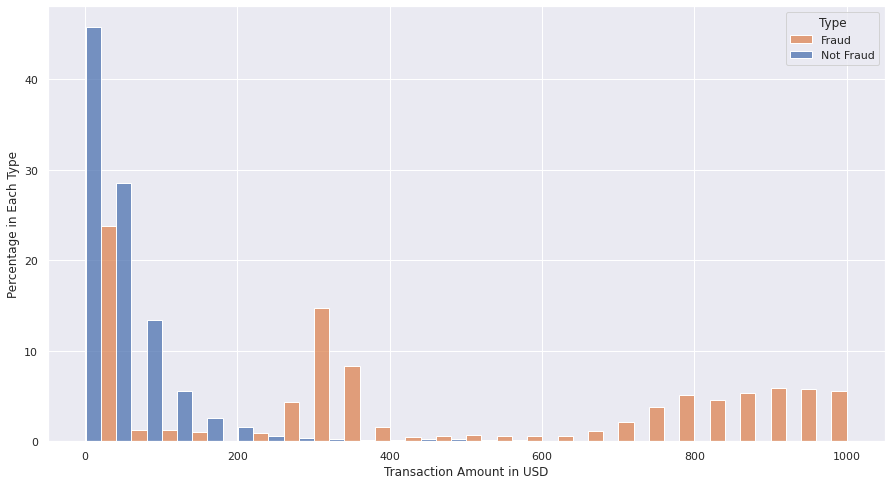

In [10]:
#amount vs fraud
ax=sns.histplot(x='amt',data=df[df.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

The result is very interesting! While normal transactions tend to be around \\$200 or less, we see fraudulent transactions peak around \\$300 and then at the \$800-\\$1000 range. There is a very clear pattern here!

## 2. Gender vs Fraud
Second, we will examine whether one gender is more susceptible to fraud than the other.

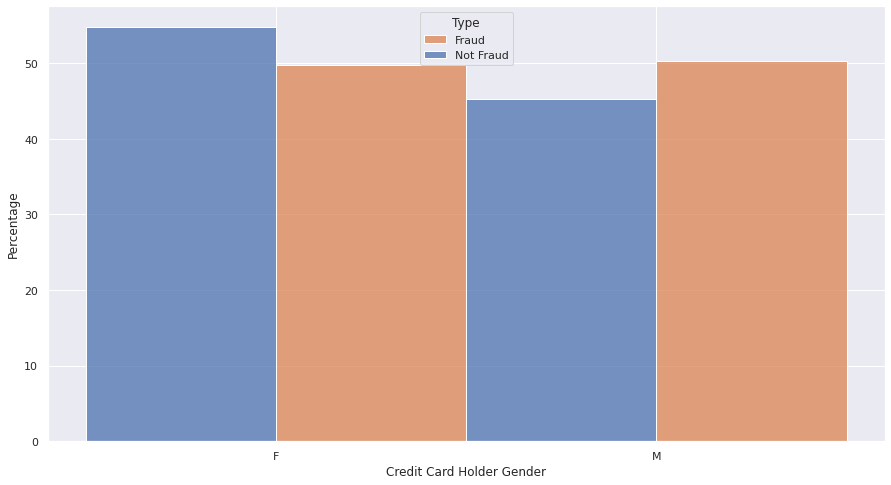

In [11]:
#Gender vs Fraud
ax=sns.histplot(x='gender',data=df, hue='is_fraud',stat='percent',multiple='dodge',common_norm=False)
ax.set_ylabel('Percentage')
ax.set_xlabel('Credit Card Holder Gender')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

In this case, we do not see a clear difference between both genders. Data seem to suggest that females and males are almost equally susceptible (50%) to transaction fraud. Gender is not very indicative of a fraudulent transaction.

## 3. Spending Category vs Fraud
Third, we examine in which spending categories fraud happens most predominantly. To do this, we first calculate the distribution in normal transactions and then the the distribution in fraudulent activities. The difference between the 2 distributions will demonstrate which category is most susceptible to fraud. For example, if 'grocery_pos' accounts for 50% of the total in normal transactions and 50% in fraudulent transactions, this doesn't mean that it is a major category for fraud, it simply means it is just a popular spending category in general. However, if the percentage is 10% in normal but 30% in fraudulent, then we know that there is a pattern.

Text(0.5, 1.0, 'The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')

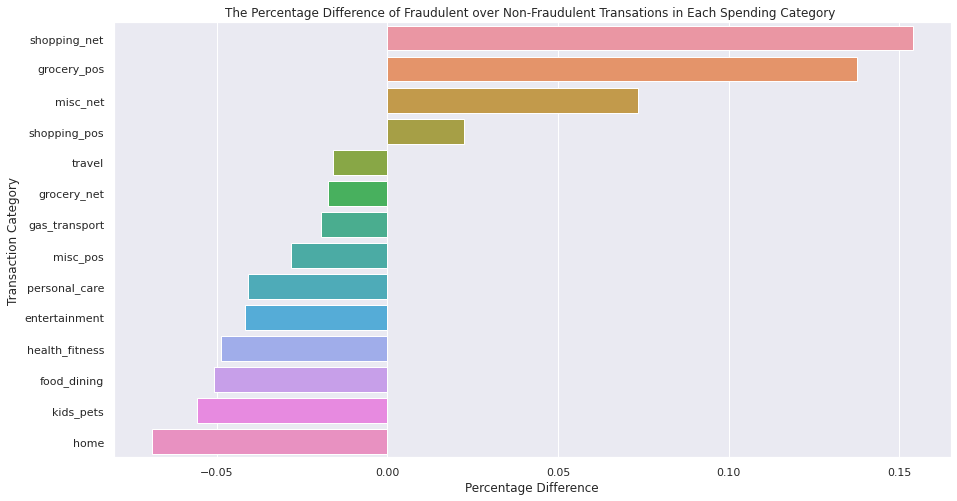

In [12]:
#calculate the percentage difference
a=df[df['is_fraud']==0]['category'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['category','not fraud percentage']

b=df[df['is_fraud']==1]['category'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['category','fraud percentage']
ab=a.merge(b,on='category')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

ax=sns.barplot(y='category',x='diff',data=ab.sort_values('diff',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')

Some spending categories indeed see more fraud than others! Fraud tends to happen more often in 'Shopping_net', 'Grocery_pos', and 'misc_net' while 'home' and 'kids_pets' among others tend to see more normal transactions than fraudulent ones. 

## 4. Age vs Fraud
Are older people more prone to credit card fraud? Or is it the other way around? Given the birthday info, we can calculate the age of each card owner (in 2022) and see whether a trend exists. 

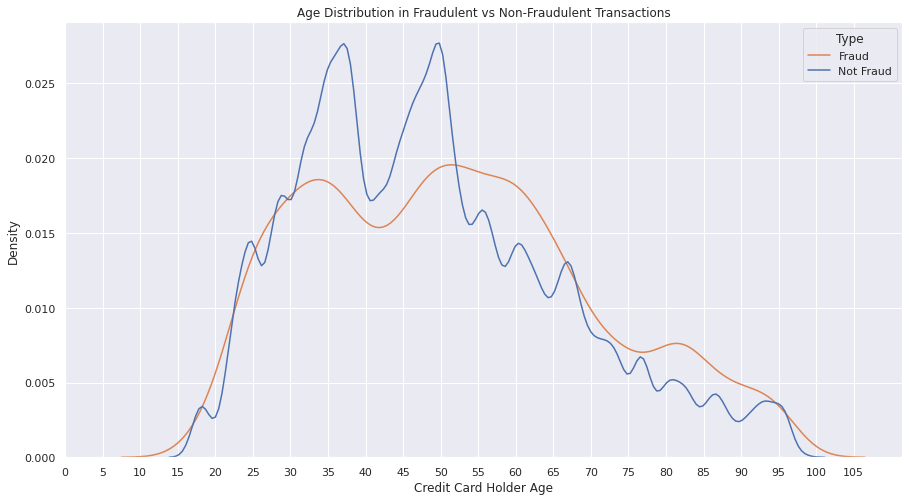

In [13]:
#age vs fraud
import datetime as dt
df['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
ax=sns.kdeplot(x='age',data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,5))
plt.title('Age Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

The age distribution is visibly different between 2 transaction types. In normal transactions, there are 2 peaks at the age of 37-38 and 49-50, while in fraudulent transactions, the age distribution is a little smoother and the second peak does include a wider age group from 50-65. This does suggest that older people are potentially more prone to fraud.

## 5. Cyclicality of Credit Card Fraud

How do fraudulent transactions distribute on the temporal spectrum? Is there an hourly, monthly, or seasonal trend? We can use the transaction time column to answer this question.

#### Hourly Trend

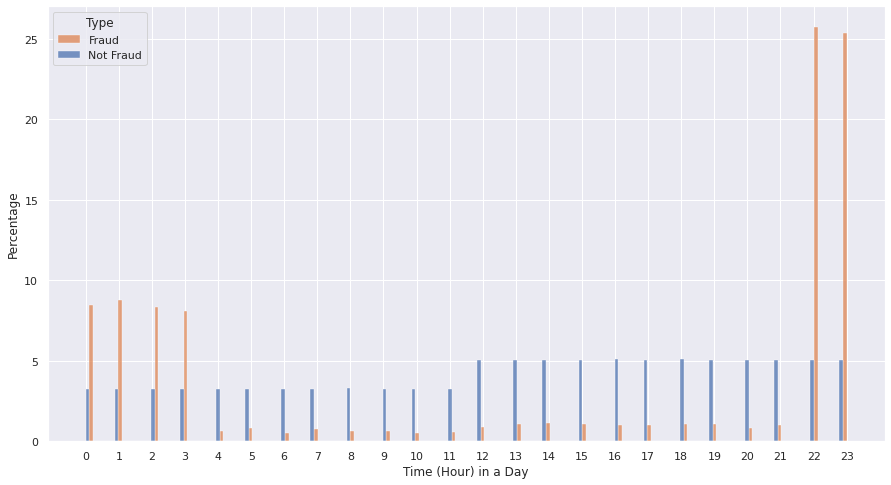

In [14]:
#time in a day vs fraud
df['hour']=pd.to_datetime(df['trans_date_trans_time']).dt.hour
ax=sns.histplot(data=df, x="hour", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Time (Hour) in a Day')
plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

A very sharp contrast! While normal transactions distribute more or less equally throughout the day, fraudulent payments happen disproportionately around midnight when most people are asleep!

#### Weekly Trend

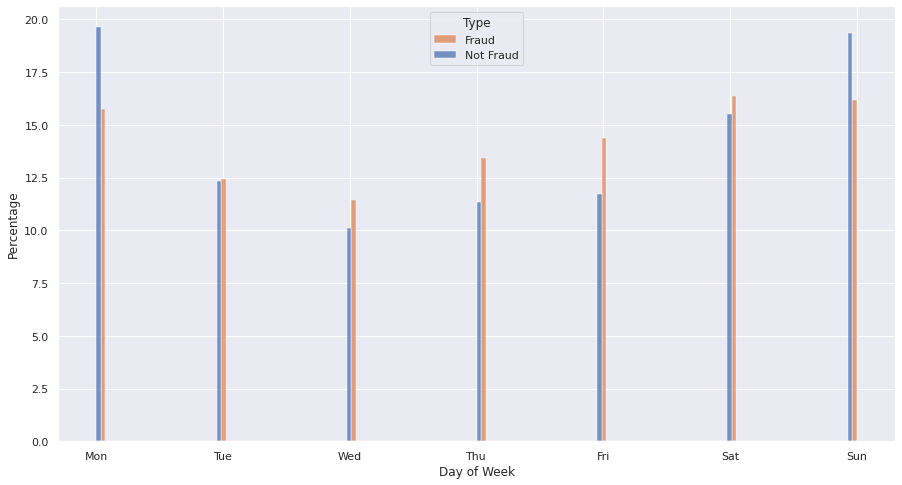

In [15]:
#day of week vs fraud
df['day']=pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
ax=sns.histplot(data=df, x="day", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day of Week')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

Normal transactions tend to happen more often on Monday and Sunday while fraudulent ones tend to spread out more evenly throughout the week. 

#### Monthly Trend

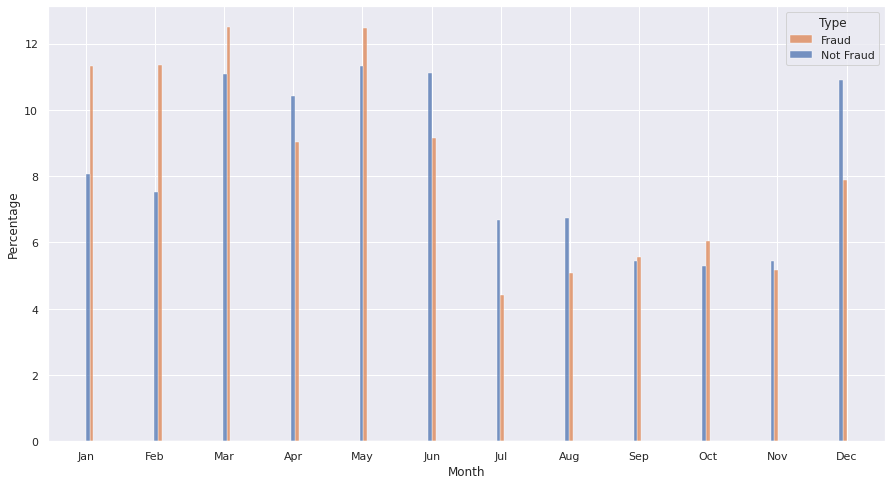

In [16]:
#month vs fraud
df['month']=pd.to_datetime(df['trans_date_trans_time']).dt.month
ax=sns.histplot(data=df, x="month", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

Very interesting results! While normal payments peak around December (Christmas), and then late spring to early summer, fraudulent transactions are more concentrated in Jan-May. There is a clear seasonal trend.

## 6. State vs Fraud
Now that we have examined fraud on the temporal level, let's also explore which geographies are more prone to fraud. We will use the same methodology as in Part 3, where we calculate the difference in geographical distribution between the 2 transaction types.

Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

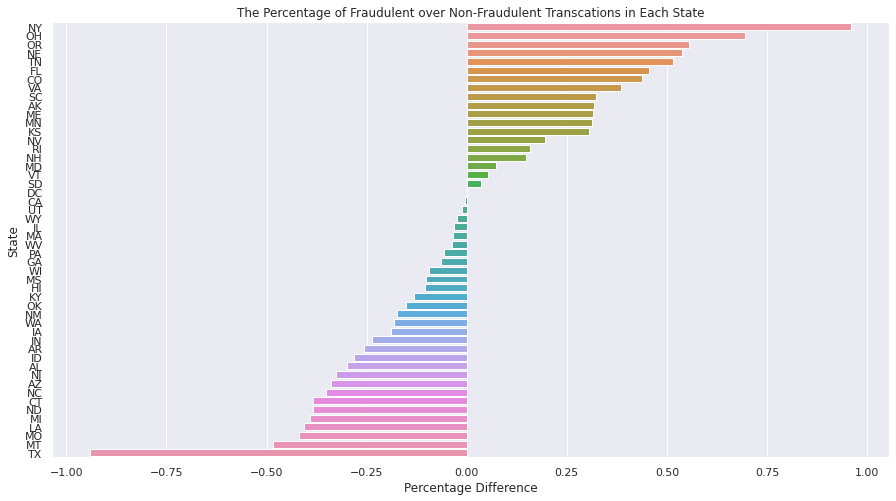

In [17]:
a=df['state'][df.is_fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['State', 'Per']

b=df['state'][df.is_fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['State', 'Per']
merged=a.merge(b,on='State')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

ax1=sns.barplot(data=merged, x='diff',y='State')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('State')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

As can be seen, NY and OH among others have a higher percentage of fraudulent transactions than normal ones, while TX and MT are the opposite. However, it should be pointed out that the percentage differences in those states are not very significant but a correlation does exist. 

# Data Modeling and Prediction

Based on our EDA above, we have found out that the features including transaction amout, credit card holder age, spending category, transaction time and locations all have varying degrees of correlations with credit card fraud. This helps us choose which features we want to include in our data models. The plan is to train the models on the dataset which we have analyzed above and then use the testing dataset to evaluate the model performance.

As data models need numeric input, we need to convert some of our categorical observations into numeric ones. For transaction locations and merchant locations, we already have the longitudinal and latitudinal data. But for shopping categories, we need convert them into dummy variables using pandas.get_dummies.

In [18]:
#subset the training data to include only the features that we need
train=df[['category','amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','is_fraud']]
#convert category to dummy variables
train=pd.get_dummies(train, drop_first=True)
y_train=train['is_fraud'].values
X_train=train.drop("is_fraud", axis='columns').values

In [19]:
#let's do the same to the testing dataset
test=pd.read_csv('/content/drive/MyDrive/insaid/fraudTest.csv')
test['age']=dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour']=pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['day']=pd.to_datetime(test['trans_date_trans_time']).dt.dayofweek
test['month']=pd.to_datetime(test['trans_date_trans_time']).dt.month
test=test[['category','amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','is_fraud']]
#convert category to dummy variables
test=pd.get_dummies(test, drop_first=True)
y_test=test['is_fraud'].values
X_test=test.drop("is_fraud", axis='columns').values

Now with both datasets cleaned and organized, we can start building models with them. We will first try to use Logistic Regression combined with confusion matrix to evaluate the model. As is very common with fraud data, there is always the issue of class imbalance where actual fraud cases are way fewer than normal cases and constitute only a very small part of the dataset. To counter this imbalance, it's important to use the SMOTE (Synthetic Minority Oversampling Technique) method to resample the training dataset so that the model can be trained on more balanced data for better results.

In [20]:
#logistic regression
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

method= SMOTE()
X_resampled, y_resampled = method.fit_resample(X_train, y_train)
model=LogisticRegression()
model.fit(X_resampled,y_resampled)
predicted=model.predict(X_test)
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.05      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719

Confusion matrix:
 [[524708  28866]
 [   534   1611]]
Share of Non-Fraud in Test Data: 0.9961


To evaluate fraud detection models, the concepts of sensitivty/recall and precision are very important. Recall is True Positives/(True Positives + False Negatives), which meaures how many fraud cases fly under the radar while precision (True Positives/(True Positives + False Positives)) evaluates how good the model is at generating as fewer false alarms as possible. For fraud detection, we want to prioritize high recall to leave out as few fraud cases as possible while also having a relatively high precision because too many false alarms can also be a problem!

In the Logistic Regression model above, the recall is around 0.75 and the general accuracy of the model is around 0.95, which is lower than the actual share of non-fraud cases in the testing dataset. Both metrics seem to suggest that the model does not add very much to detecting fraud. Moreover, the Precision of the model is only 0.05: too many false positives to be actually useful!

We will now try using another algorithm--Random Forest, to see if a better model can be created.

In [21]:
#random forest 
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(random_state=5)
model2.fit(X_resampled,y_resampled)
predicted=model2.predict(X_test)
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.89      0.73      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719

Confusion matrix:
 [[553373    201]
 [   587   1558]]
Share of Non-Fraud in Test Data: 0.9961


In [22]:
#DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
model3 = DecisionTreeClassifier()
model3.fit(X_resampled,y_resampled)
predicted=model3.predict(X_test)
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.77      0.71      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.89      0.86    555719
weighted avg       1.00      1.00      1.00    555719

Confusion matrix:
 [[552737    837]
 [   488   1657]]
Share of Non-Fraud in Test Data: 0.9961


The above metrics show that although the Random Forest model has a slightly lower recall, it has much better accuracy and precision! Although still in need of improvements, it serves as a way better basis than the Logistic Regression model above for future deployment.